In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
df=pd.read_csv('RSCCASN.csv',index_col='DATE',date_format='%Y-%m-%d')

In [11]:
df1=pd.read_csv('RSCCASN.csv', index_col='DATE', parse_dates=['DATE'])

In [53]:
df1, print(df1.index.dtype)

datetime64[ns]


(            RSCCASN
 DATE               
 1992-01-01     6938
 1992-02-01     7524
 1992-03-01     8475
 1992-04-01     9401
 1992-05-01     9558
 ...             ...
 2019-06-01    21123
 2019-07-01    21714
 2019-08-01    23791
 2019-09-01    19695
 2019-10-01    21113
 
 [334 rows x 1 columns],
 None)

In [45]:
df.columns=['Sales']

<Axes: xlabel='DATE'>

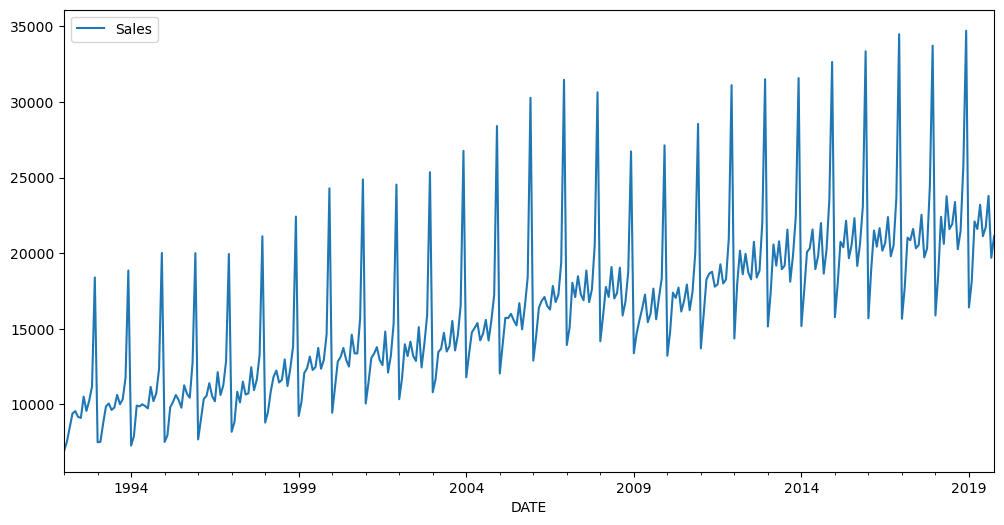

In [49]:
df.plot(figsize=(12,6))

In [55]:
len(df)

334

In [59]:
test_index=len(df)-18 ###take 18 month for test data
test_index

316

In [61]:
train=df.iloc[:test_index]
test=df.iloc[test_index:]

In [67]:
len(train)

316

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
scale=MinMaxScaler()

In [69]:
scale.fit(train)

MinMaxScaler()

In [71]:
train_scale=scale.transform(train)
test_scale=scale.transform(test)

In [75]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [77]:
length=12  ##1 year of data
generator=TimeseriesGenerator(train_scale,train_scale,length=length,batch_size=1)
validation_generator=TimeseriesGenerator(test_scale,test_scale,length=length,batch_size=1)

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [103]:
n_feature=1

In [105]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_feature)))  #default activation is tanh
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [107]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [111]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


C:\Users\mrsna\AppData\Local\Temp\ipykernel_21784\3786894748.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])


304/304 [==============================] - 8s 15ms/step - loss: 0.0218 - val_loss: 0.0059
Epoch 2/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0159 - val_loss: 0.0270
Epoch 3/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0111 - val_loss: 6.6039e-04
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0046 - val_loss: 2.5504e-04
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 6/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0021 - val_loss: 0.0013


In [113]:
df_loss=pd.DataFrame(model.history.history)

<Axes: >

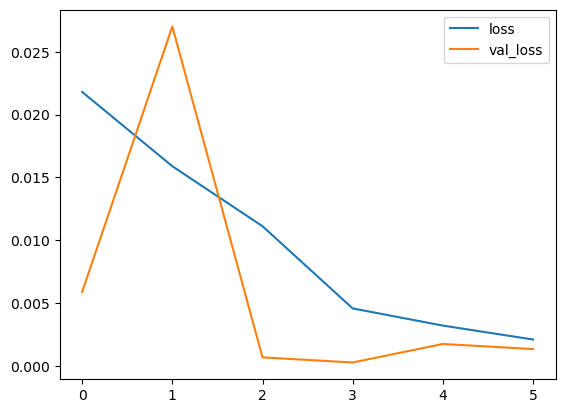

In [115]:
df_loss.plot()

In [117]:
test_prediction=[]
first_eval_batch=train_scale[-length:]
current_batch=first_eval_batch.reshape((1,length,n_feature))  ##batch,len,features

for i in range(len(test)):
    pred=model.predict(current_batch)[0]
    test_prediction.append(pred)
    current_batch=np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 [==============================] - 0s 56ms/step


In [119]:
true_predic=scale.inverse_transform(test_prediction)

In [123]:
test['Predictions']=true_predic

C:\Users\mrsna\AppData\Local\Temp\ipykernel_21784\23821940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predic


In [125]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22007.233953
2018-06-01,21589,21014.378870
2018-07-01,21919,21275.814477
2018-08-01,23381,22929.672722
2018-09-01,20260,20690.135642
2018-10-01,21473,21310.833012
2018-11-01,25831,24911.010906
2018-12-01,34706,35286.598855
2019-01-01,16410,17005.703121


<Axes: xlabel='DATE'>

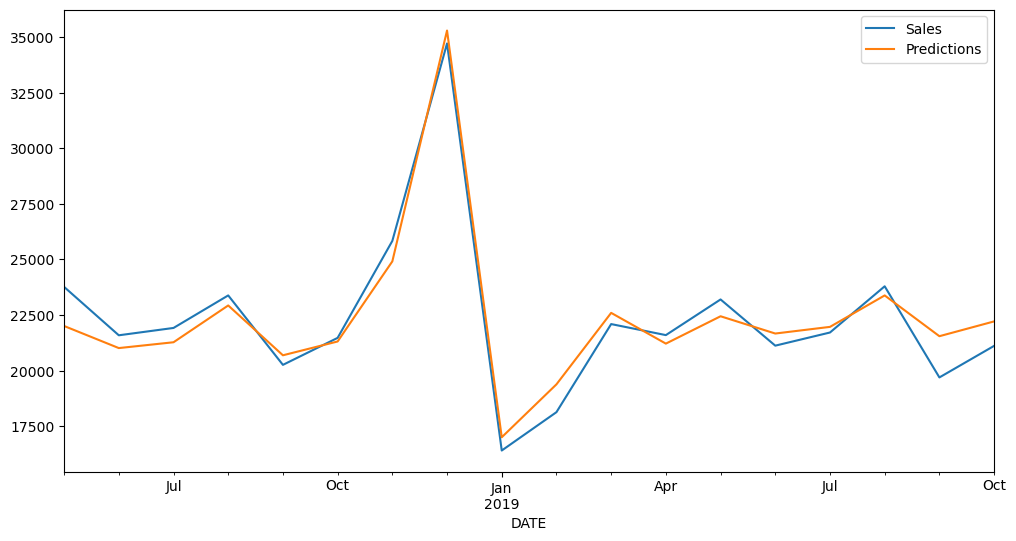

In [127]:
test.plot(figsize=(12,6))

### The above model will use to predict future data

In [200]:
full_scaler=MinMaxScaler()
data_scaled=full_scaler.fit_transform(df)

In [202]:
length=12
full_generator=TimeseriesGenerator(data_scaled,data_scaled,length=length,batch_size=1)

In [204]:
n_feature=1
n_feature

1

In [206]:
model1=Sequential()
model1.add(LSTM(100,activation='relu',input_shape=(length,n_feature)))  #default activation is tanh
model1.add(Dense(1))
model1.compile(loss='mse',optimizer='adam')

In [208]:
model1.fit(full_generator,epochs=3)

Epoch 1/3
322/322 [==============================] - 6s 9ms/step - loss: 0.0255
Epoch 2/3
322/322 [==============================] - 3s 9ms/step - loss: 0.0184
Epoch 3/3
322/322 [==============================] - 3s 8ms/step - loss: 0.0149


In [210]:
forecast=[]
periods=12  ##month of forecast
first_eval_batch=data_scaled[-length:]
current_batch=first_eval_batch.reshape(1,length,n_feature)

for i in range(periods):
    pred=model1.predict(current_batch)[0]
    forecast.append(pred)
    current_batch=np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 [==============================] - 0s 47ms/step


In [212]:
forecast=full_scaler.inverse_transform(forecast)

In [214]:
forecast

array([[25325.16781044],
       [28611.67527056],
       [19005.67724252],
       [19939.6660707 ],
       [21716.75464058],
       [21546.30398417],
       [22277.66863251],
       [21328.80374956],
       [21627.71347523],
       [22548.25460148],
       [20669.95159268],
       [21456.6024332 ]])

In [216]:
df[-1:]

,Sales
DATE,
2019-10-01,21113


### want to add the forecst with timestamp as index

In [218]:
forecast_index=pd.date_range(start='2019-11-01',periods=len(forecast),freq='MS')  ##MS monthly start, M monthly end
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [220]:
df_forecast=pd.DataFrame(forecast,index=forecast_index,columns=['Forecast'])

In [222]:
df_forecast, print(df_forecast.index.dtype)

datetime64[ns]


(                Forecast
 2019-11-01  25325.167810
 2019-12-01  28611.675271
 2020-01-01  19005.677243
 2020-02-01  19939.666071
 2020-03-01  21716.754641
 2020-04-01  21546.303984
 2020-05-01  22277.668633
 2020-06-01  21328.803750
 2020-07-01  21627.713475
 2020-08-01  22548.254601
 2020-09-01  20669.951593
 2020-10-01  21456.602433,
 None)

<Axes: >

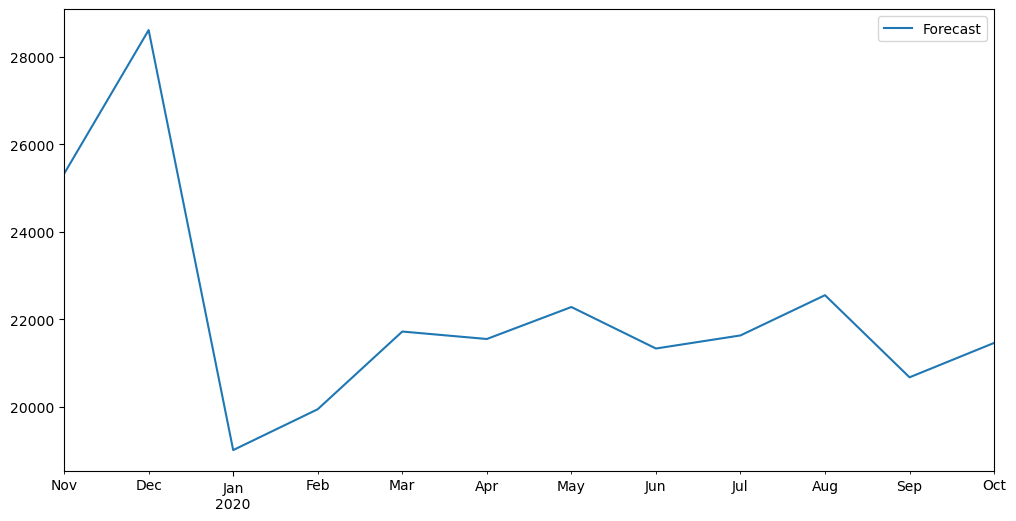

In [224]:
# df.plot()
df_forecast.plot(figsize=(12,6))

(576.0, 611.0)

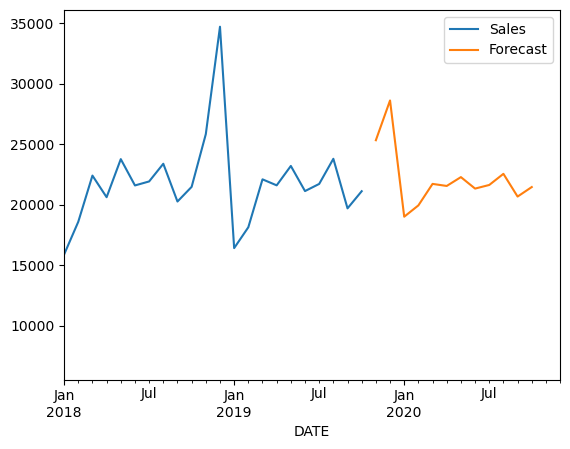

In [228]:
# plot in one graph
ax=df.plot()
df_forecast.plot(ax=ax)

plt.xlim('2018-01-01','2020-12-01')